In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import optax
from flax import nnx
import orbax.checkpoint as ocp

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt
from jax.experimental.ode import odeint

import jaxpm
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces, make_ode_fn_diffrax, make_ode_fn
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm.utils import power_spectrum

from jaxpm.nn import MLP
from jaxpm import camels, plotting, hpm, nn

jax.devices("gpu")

[cuda(id=0)]

In [4]:
%load_ext tensorboard
from flax.metrics import tensorboard

2024-12-20 16:33:04.971506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# configuration

In [5]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

# CAMELS

In [6]:
list(range(1, 33+4, 4))

[1, 5, 9, 13, 17, 21, 25, 29, 33]

In [7]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"
# SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1"

out_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    # i_snapshots=[-2,-1],
    # i_snapshots=range(1, 33+4, 8),
    i_snapshots=range(1, 33+4, 4),
    return_hydro=True,
)

cosmo = out_dict["cosmo"]
scales = out_dict["scales"]

dm_poss = out_dict["dm_poss"]
dm_vels = out_dict["dm_vels"]

gas_poss = out_dict["gas_poss"]
gas_vels = out_dict["gas_vels"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_018.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_034.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_042.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_050.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_058.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_066.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_074.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_082.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 9/9 [01:30<00:00, 10.10s/it]


# fine tune the HPM-table network with particle positions

In [66]:
model = MLP(
    d_in=3, 
    d_out=1, 
    d_hidden=64, 
    n_hidden=4, 
    rngs=nnx.Rngs(0)
)

In [67]:
# abstract_model = nnx.eval_shape(lambda: model)
# graphdef, abstract_params = nnx.split(abstract_model)

# checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp_v2.jx")
# checkpointer = ocp.StandardCheckpointer()
# params = checkpointer.restore(checkpoint_file, abstract_params)
# model = nnx.merge(graphdef, params)

In [68]:
summary_writer = tensorboard.SummaryWriter('logs/particle_level')

# per-particle reference
ref_pos = jnp.stack(gas_poss, axis=0)
ref_vel = jnp.stack(gas_vels, axis=0)

# power spectrum reference
vcic_paint = jax.vmap(cic_paint, in_axes=(None,0))
vpower_spectrum = jax.vmap(
    lambda fields: 
        power_spectrum(
            compensate_cic(fields),
            boxsize=np.array([25.0] * 3),
            kmin=np.pi / 25.0,
            dk=2 * np.pi / 25.0,
        )
)
ref_rho = vcic_paint(jnp.zeros(mesh_shape), ref_pos)
_, ref_cls = vpower_spectrum(ref_rho)

@nnx.jit
def train_step(model, optimizer):

    def loss_fn(model):
        res = odeint(
            hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, force_type="table"), 
            [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]],
            scales,
            rtol=1e-2, 
            atol=1e-2
        )
        # pos_loss = jnp.sum((res[2] - ref_pos)**2, axis=-1)
        pos_loss = jnp.sum((res[2]%64 - ref_pos)**2, axis=-1)

        pos_loss = jnp.where(pos_loss < mesh_per_dim//2, pos_loss, 0.)
        # pos_loss *= jnp.expand_dims(scales, axis=1)
        pos_loss = jnp.mean(pos_loss)

        vel_loss = jnp.sum((res[3] - ref_vel)**2, axis=-1)
        vel_loss = jnp.where(vel_loss < mesh_per_dim//2, vel_loss, 0.)
        # vel_loss *= jnp.expand_dims(scales, axis=1)
        vel_loss = jnp.mean(vel_loss)

        # res_rho = vcic_paint(jnp.zeros(mesh_shape), res[2])
        # _, res_cls = vpower_spectrum(res_rho)
        # cl_loss = jnp.mean(jnp.sum((res_cls/ref_cls - 1)**2, axis=-1))
        
        # return pos_loss + 0.1 * vel_loss + 0.1 * cl_loss
        return pos_loss + 0.01 * vel_loss
        # return pos_loss + 0.01 * vel_loss
        # return pos_loss + vel_loss
        # return pos_loss

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

losses = []

In [69]:
# %tensorboard --logdir=logs/particle_level

In [70]:
total_steps = 100
learning_rate = 1e-3
# learning_rate = optax.cosine_decay_schedule(
#     init_value=1e-3, 
#     decay_steps=total_steps, 
#     alpha=0.1
# )
clip_norm = 1

optimizer = nnx.Optimizer(
    model,
    optax.chain(
        optax.clip_by_global_norm(clip_norm),
        optax.adam(learning_rate)
    )
)

Loss: 0.7124: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


[None]

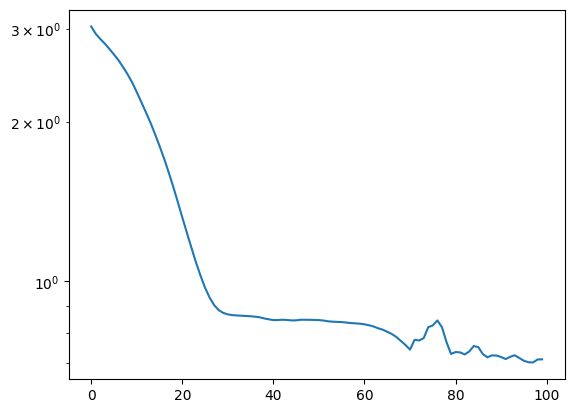

In [71]:
for i in (pbar := tqdm.tqdm(range(total_steps))):    
    loss = train_step(model, optimizer)
    losses.append(loss)

    pbar.set_description(f"Loss: {loss:.4f}")

    # if i % 10 ==0:
    #     summary_writer.scalar('train_loss', loss, i)
    #     summary_writer.scalar('learning_rate', lr_scheduler(i), i)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set(yscale="log")

In [195]:
# 0.9161

In [157]:
# # see https://flax.readthedocs.io/en/latest/guides/checkpointing.html
# # checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp.jx")
# checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp_v3.jx")
# checkpointer = ocp.StandardCheckpointer()

In [158]:
# _, params = nnx.split(model)
# checkpointer.save(checkpoint_file, params, force=True)

In [159]:
# abstract_model = nnx.eval_shape(lambda: model)
# graphdef, abstract_params = nnx.split(abstract_model)

# params = checkpointer.restore(checkpoint_file, abstract_params)
# model = nnx.merge(graphdef, params)

# run the simulation

In [72]:
pm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint", gravity_only=True)

res = odeint(pm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-5, atol=1e-5)
pm_dm_poss, pm_dm_vels, pm_gas_poss, pm_gas_vels = res[0], res[1], res[2], res[3]

In [73]:
hpm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint")

res = odeint(hpm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-5, atol=1e-5, mxstep=20)
hpm_dm_poss, hpm_dm_vels, hpm_gas_poss, hpm_gas_vels = res[0], res[1], res[2], res[3]

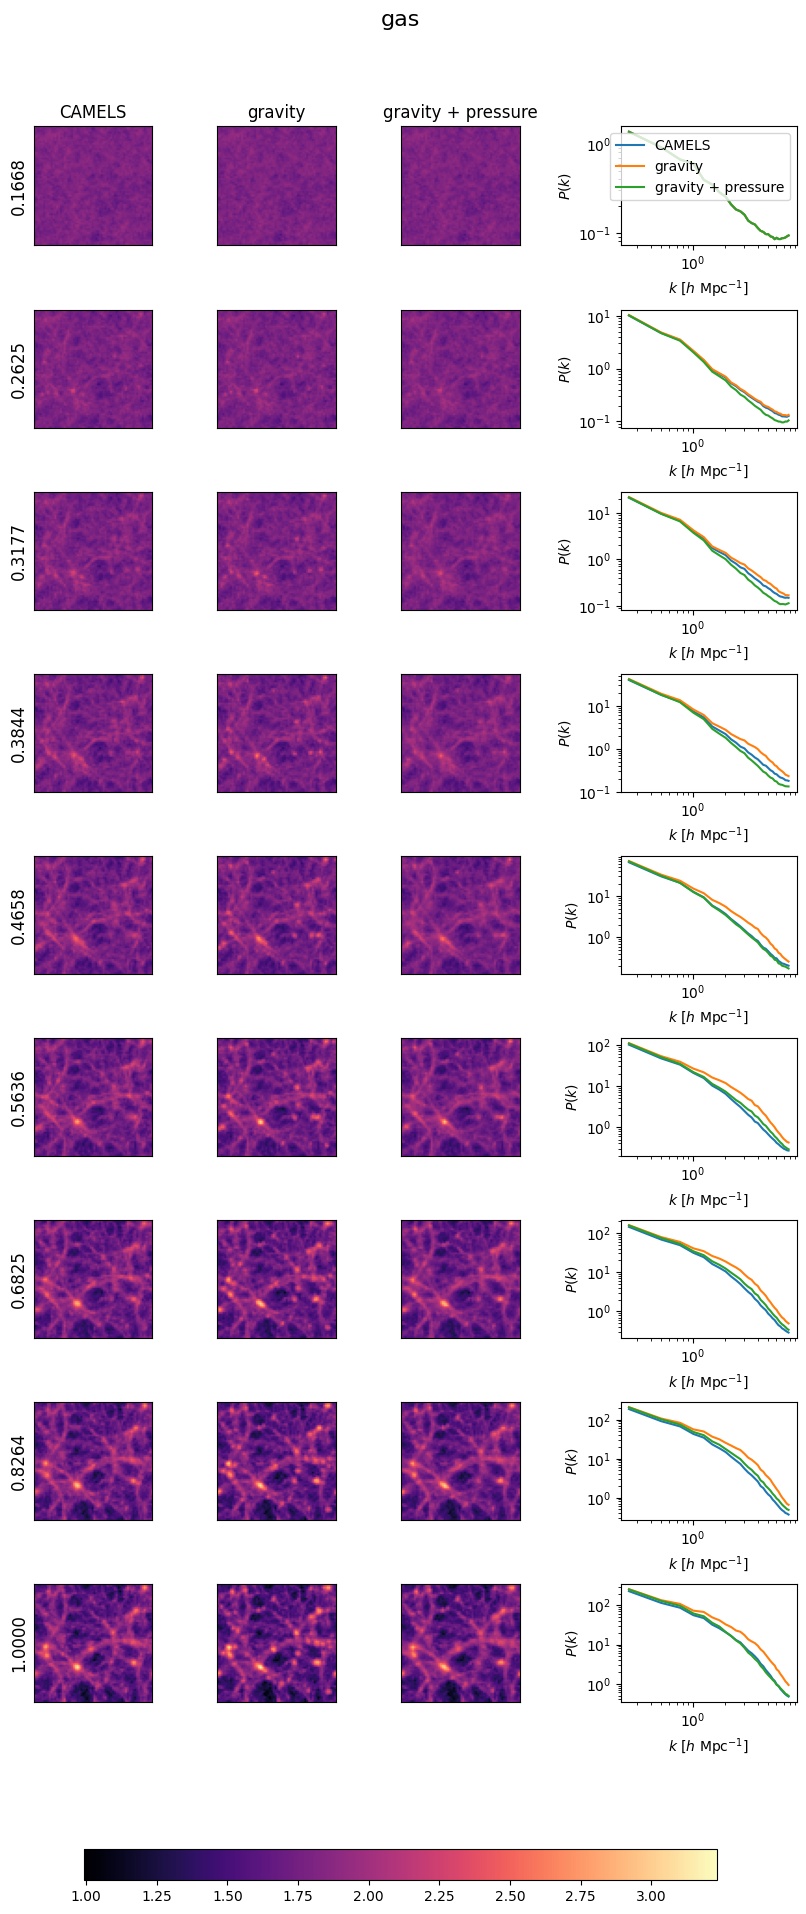

In [74]:
plotting.compare_particle_evolution(
    mesh_shape, 
    scales, 
    jnp.stack([gas_poss, pm_gas_poss, hpm_gas_poss], axis=0), 
    title="gas",
    col_titles=["CAMELS", "gravity", "gravity + pressure"],
    include_pk=True,
)

In [18]:
# plotting.compare_particle_evolution(
#     mesh_shape, 
#     scales, 
#     jnp.stack([gas_poss, hpm_gas_poss], axis=0), 
#     title="gas",
#     col_titles=["CAMELS", "gravity + pressure"],
#     include_pk=True,
# )

In [19]:
# plotting.compare_particle_evolution(
#     mesh_shape, 
#     scales, 
#     jnp.stack([gas_poss, pm_gas_poss], axis=0), 
#     title="gas",
#     col_titles=["CAMELS", "gravity"],
#     include_pk=True,
# )